# CIFAR10 feature extraction using pretrained convolutional deep neural networks from keras library

Here, we explain the process of extracting features from CIFAR10 dataset images (both training and testing) using pretrained convolutional deep neural networks. 

We used the [keras](https://keras.io/) python deep learning library.
Namely, we used the following networks from [keras.applications](https://keras.io/applications/):
* <strike>Xception</strike>
* VGG16
* <strik>VGG19</strike>
* ResNet50
* InceptionV3
* <strike>MobileNet</strike>

All of them can be initialized to be already pretrained on ImageNET dataset.
Here is the example to load the Inception_v3 CNN with keras
```python
from keras.applications.inception_v3 import InceptionV3
model = InceptionV3(include_top=False, weights='imagenet', \
                    input_tensor=None, input_shape=None, pooling=None, classes=1000)
```
The most important for **transfer learning** is to give the paramater
```python
include_top=False
```

since it builds the CNN model without the last (top) layer which is responsible to classify ImageNET categorized to 1000 classes. As we will see later, such models can be used for extracting the features from CIFAR10 images (only 10 classes) and later to classify them using simple linear classifier like SVM (with linear kernel).

In [1]:
network_names = [ 'incv3', 'resnet50', 'vgg16', 'vgg19' ]

print("Available networks = ", network_names)
cnnid = int( input("Please choose the CNN network [0-{n}]: ".format(n=len(network_names)-1)) )
selected_network = network_names[cnnid]
print("Selected network: ", selected_network)

Available networks =  ['incv3', 'resnet50', 'vgg16', 'vgg19']
Please choose the CNN network [0-4]: 0
Selected network:  incv3


In [2]:
import time
import myutils
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, AveragePooling2D, GlobalAveragePooling2D
from keras import backend as K

Using TensorFlow backend.


# Load CIFAR10 data
Here we use [keras.datasets](https://keras.io/datasets/) which is pretty similar to our <tt>myutils.load_CIFAR10_dataset()</tt> procedure.

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


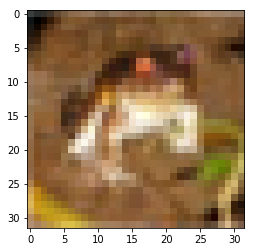

In [25]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

n_training = X_train.shape[0]
n_testing = X_test.shape[0]

y_train = y_train.flatten()
y_test  = y_test.flatten()

print( X_train.shape, y_train.shape,  X_test.shape, y_test.shape )

from matplotlib import pyplot as plt
plt.imshow( X_train[0]  )
plt.show()

# Create model

In [9]:
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50     import ResNet50
from keras.applications.vgg16        import VGG16
from keras.applications.vgg19        import VGG19

input_shape = {
    'incv3'   : (299,299,3),
    'resnet50': (224,224,3),
    'vgg16'   : (224,224,3),
    'vgg19'   : (224,224,3)
}[selected_network]

def create_model_incv3():
    tf_input = Input(shape=input_shape)
    model = InceptionV3(input_tensor=tf_input, weights='imagenet', include_top=False)
    output_pooled = AveragePooling2D((8, 8), strides=(8, 8))(model.output)
    return Model(model.input, output_pooled)

def create_model_resnet50():
    tf_input = Input(shape=input_shape)
    return ResNet50(input_tensor=tf_input, include_top=False)

def create_model_vgg16():
    tf_input = Input(shape=input_shape)
    model = VGG16(input_tensor=tf_input, include_top=False)
    output_pooled = AveragePooling2D((7, 7))(model.output)
    return Model(model.input, output_pooled )

def create_model_vgg19():
    tf_input = Input(shape=input_shape)
    model = VGG16(input_tensor=tf_input, include_top=False)
    output_pooled = AveragePooling2D((7, 7))(model.output)
    return Model(model.input, output_pooled )

create_model = {
    'incv3'    : create_model_incv3,
    'resnet50' : create_model_resnet50,
    'vgg16'    : create_model_vgg16,
    'vgg19'    : create_model_vgg19
}[selected_network]

# Data generator for tensorflow

The feature extraction can process the batches of data. It is common in feeding neural networks in tensorflow.

In [5]:
# tensorflow placeholder for batch of images from CIFAR10 dataset
batch_of_images_placeholder = tf.placeholder("uint8", (None, 32, 32, 3))

batch_size = {
    'incv3'    : 16,
    'resnet50' : 16,
    'vgg16'    : 16,
    'vgg19'    : 16
}[selected_network]

# Inception default size is 299x299
tf_resize_op = tf.image.resize_images(batch_of_images_placeholder, (input_shape[:2]), method=0)

In [6]:
# data generator for tensorflow session
from keras.applications.inception_v3 import preprocess_input as incv3_preprocess_input
from keras.applications.resnet50     import preprocess_input as resnet50_preprocess_input
from keras.applications.vgg16        import preprocess_input as vgg16_preprocess_input
from keras.applications.vgg19        import preprocess_input as vgg19_preprocess_input

preprocess_input = {
    'incv3'   : incv3_preprocess_input,
    'resnet50': resnet50_preprocess_input,
    'vgg16'   : vgg16_preprocess_input,
    'vgg19'   : vgg19_preprocess_input
}[selected_network]

def data_generator(sess,data,labels):
    def generator():
        start = 0
        end = start + batch_size
        n = data.shape[0]
        while True:
            batch_of_images_resized = sess.run(tf_resize_op, {batch_of_images_placeholder: data[start:end]})
            batch_of_images__preprocessed = preprocess_input(batch_of_images_resized)
            batch_of_labels = labels[start:end]
            start += batch_size
            end   += batch_size
            if start >= n:
                start = 0
                end = batch_size
            yield (batch_of_images__preprocessed, batch_of_labels)
    return generator

# Feature extraction

In [7]:
with tf.Session() as sess:
    # setting tensorflow session to Keras
    K.set_session(sess)
    # setting phase to training
    K.set_learning_phase(0)  # 0 - test,  1 - train

    model = create_model()

    data_train_gen = data_generator(sess, X_train, y_train)
    ftrs_training = model.predict_generator(data_train_gen(), n_training/batch_size, verbose=1)

    data_test_gen = data_generator(sess, X_test, y_test)
    ftrs_testing = model.predict_generator(data_test_gen(), n_testing/batch_size, verbose=1)

625/625 [==============================] - 145s   


In [ ]:
features_training = np.array( [ftrs_training[i].flatten() for i in range(n_training)] )
features_testing  = np.array( [ftrs_testing[i].flatten()  for i in range(n_testing )] )

np.savez_compressed("features/CIFAR10_{}-keras_features.npz".format(selected_network), \
                    features_training=features_training, \
                    features_testing=features_testing,   \
                    labels_training=y_train,             \
                    labels_testing=y_test)

In [22]:
features_training.shape, features_testing.shape

((50000, 2048), (10000, 2048))

In [28]:
print('Ten first features of X_train[0] (see figure above, with the frog)')
features_training[0][0:10]

Ten first features of X_train[0] (see figure above, with the frog)


array([ 0.27140674,  0.52113253,  0.24185033,  0.20671989,  0.30322665,
        0.34751841,  0.36889949,  0.25563717,  0.27236217,  0.16386187], dtype=float32)

Ten first features of X_train[0] (see figure above, with the frog)

    'incv3':
        array([ 0.27140674,  0.52113253,  0.24185033,  0.20671989,  0.30322665,
                0.34751841,  0.36889949,  0.25563717,  0.27236217,  0.16386187], dtype=float32)

# Feature visualization

Here we visualize the features extracted by the pretrained CNN network.

## Feature analysis (using PCA)

In [30]:
import numpy as np
import myutils

data = np.load("features/CIFAR10_{}-keras_features.npz".format(selected_network))

X_training = data['features_training']
y_training = data['labels_training']

X_testing = data['features_testing']
y_testing = data['labels_testing']

# data_training, data_testing = myutils.load_CIFAR_dataset(shuffle=False)
# assert( (np.array( [data_training[i][1] for i in range(len(data_training))] ) == y_training).all() )
# assert( (np.array( [data_testing[i][1] for i in range(len(data_testing))] ) == y_testing).all() )
print( 'X_training size = {}'.format(X_training.shape))

X_training size = (50000, 2048)


In [31]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(X_training)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [32]:
print(pca.explained_variance_ratio_)

[ 0.03887677  0.02717801]


In [33]:
X = pca.transform(X_training)

In [34]:
X.shape

(50000, 2)

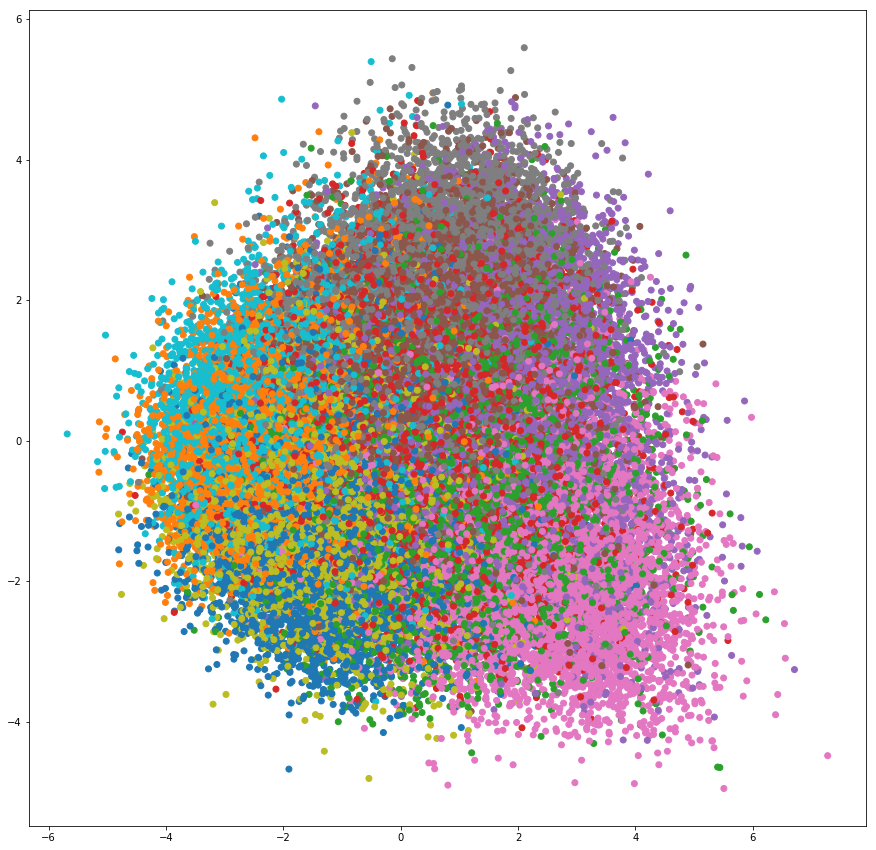

In [35]:
from matplotlib import pyplot as plt
plt.figure( figsize=(15,15) )
plt.scatter( X[:, 0], X[:, 1], c=y_training, cmap='tab10' )
# plt.colorbar()
plt.show()

## Feature analysis using t-SNE

In [36]:
from sklearn.manifold import TSNE
pca = decomposition.PCA(n_components=10)
X_training_reduced = pca.fit_transform(X_training)

Since t-SNE is quite complex, it is worth to compress the data. Let say that 56% is enough.

In [37]:
np.sum( pca.explained_variance_ratio_ )

0.19201337

In [38]:
tsne = TSNE(n_components=2)

In [ ]:
X_training_reduced_tsne = tsne.fit_transform(X_training_reduced)

In [ ]:
X_training_reduced_tsne.shape

In [ ]:
plt.figure( figsize=(15,15) )
plt.scatter( X_training_reduced_tsne[:, 0], X_training_reduced_tsne[:, 1], c=y_training, cmap='tab10' )
plt.show()